<a href="https://colab.research.google.com/github/Sant05hkumar06/Data-Science-Projects/blob/main/Tamil_Text_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
#Load data-preprocessing libraries
import pandas as pd
import numpy as np

#Text processing libraries
import re
import nltk
from nltk.corpus import stopwords  
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer #feature extraction

#Load data-visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#model building
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#evaluation metrics
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **1. Data Collection**

In [81]:
comment=pd.read_csv('/content/sample_data/Tamil_first_ready_for_sentiment.csv', error_bad_lines=False, delimiter='\t',header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [82]:
comment.columns = ["sentiment","review"]

In [83]:
comment.head()

,sentiment,review
0,Negative,Enna da ellam avan seyal Mari iruku
1,Negative,This movei is just like ellam avan seyal
2,Positive,Padam vanthathum 13k dislike pottavaga yellam...
3,Positive,Neraya neraya neraya... ... V era level...thala
4,Positive,wow thavala sema mass....padam oru pundaikum ...


In [84]:
comment.isnull().sum()

sentiment    0
review       0
dtype: int64

In [85]:
comment.shape

(15744, 2)

In [86]:
comment.describe()

,sentiment,review
count,15744,15744
unique,5,15578
top,Positive,Graphics sari illa nu solrathukune oru gang s...
freq,10559,8


In [87]:
comment['sentiment'].unique()

array(['Negative ', 'Positive ', 'Mixed_feelings ', 'not-Tamil ',
       'unknown_state '], dtype=object)

In [88]:
comment['sentiment'].value_counts()

Positive           10559
Negative            2037
Mixed_feelings      1801
unknown_state        850
not-Tamil            497
Name: sentiment, dtype: int64

We can see that the dataset is imbalanced.

# **2. EDA**

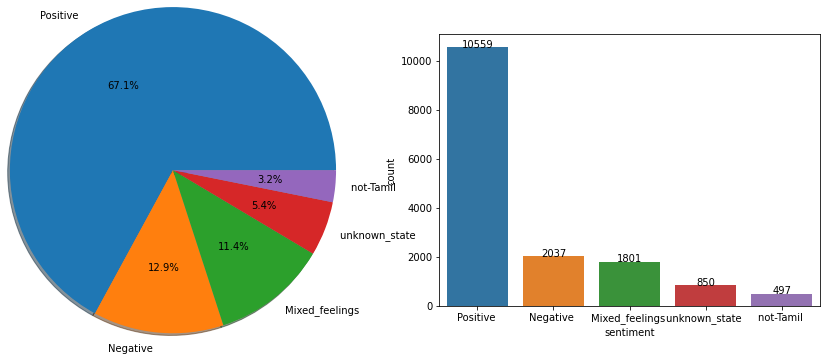

In [89]:
#Visualizing sentiment feature - Target feature
plt.figure(figsize=(15,5))

#plot pie chart
plt.subplot(1,2,1)
label = comment['sentiment'].value_counts().index
label_count = comment['sentiment'].value_counts().values
plt.pie(data=comment, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1.5)

#plot countplot
plt.subplot(1,2,2)
ax = sns.countplot(x='sentiment', data=comment, order=label)
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2),
    y=height+0.2,ha='center',s='{:.0f}'.format(height))
plt.show()

<BarContainer object of 5 artists>

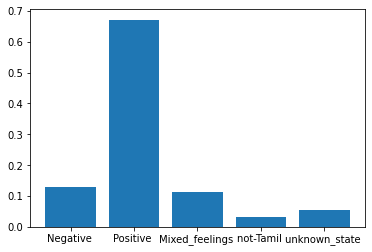

In [90]:
#Checking balance of target classes
sentiments = list(comment["sentiment"].unique())

sentiment_nums = [len(comment[comment["sentiment"] == sentiment]) / len(comment) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

# **Stop Word Removal and Lemmatisation with NLTK**

In [91]:
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [92]:
def remove_stopwords(ls):
    #Lemmatises, then removes stop words
    ls = [lemmatiser.lemmatize(word) for word in ls if word not in (stop_english) and (word.isalpha())]
    
    #Joins the words back into a single string
    ls = " ".join(ls)
    return ls

#Splits each string into a list of words
comment["review_Split"] = comment["review"].apply(word_tokenize)

#Applies the above function to each entry in the DataFrame
lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words()) #Here we use a Counter dictionary on the cached
                                          # list of stop words for a huge speed-up
comment["review_Split"] = comment["review_Split"].apply(remove_stopwords)

In [93]:
comment.head()

,sentiment,review,review_Split
0,Negative,Enna da ellam avan seyal Mari iruku,Enna ellam avan seyal Mari iruku
1,Negative,This movei is just like ellam avan seyal,This movei ellam avan seyal
2,Positive,Padam vanthathum 13k dislike pottavaga yellam...,Padam vanthathum dislike pottavaga yellam yea ...
3,Positive,Neraya neraya neraya... ... V era level...thala,Neraya neraya neraya V level thala
4,Positive,wow thavala sema mass....padam oru pundaikum ...,wow thavala sema mass padam oru pundaikum aagathu


In [94]:
comment=comment[comment['sentiment'].isin(['Negative ','Positive '])]
comment.head()

,sentiment,review,review_Split
0,Negative,Enna da ellam avan seyal Mari iruku,Enna ellam avan seyal Mari iruku
1,Negative,This movei is just like ellam avan seyal,This movei ellam avan seyal
2,Positive,Padam vanthathum 13k dislike pottavaga yellam...,Padam vanthathum dislike pottavaga yellam yea ...
3,Positive,Neraya neraya neraya... ... V era level...thala,Neraya neraya neraya V level thala
4,Positive,wow thavala sema mass....padam oru pundaikum ...,wow thavala sema mass padam oru pundaikum aagathu


In [95]:
comment.shape

(12596, 3)

In [96]:
comment['label']=comment['sentiment'].apply(lambda x: 1 if x=='Negative ' else 0)
comment.head()

,sentiment,review,review_Split,label
0,Negative,Enna da ellam avan seyal Mari iruku,Enna ellam avan seyal Mari iruku,1
1,Negative,This movei is just like ellam avan seyal,This movei ellam avan seyal,1
2,Positive,Padam vanthathum 13k dislike pottavaga yellam...,Padam vanthathum dislike pottavaga yellam yea ...,0
3,Positive,Neraya neraya neraya... ... V era level...thala,Neraya neraya neraya V level thala,0
4,Positive,wow thavala sema mass....padam oru pundaikum ...,wow thavala sema mass padam oru pundaikum aagathu,0


## **3. Creating Word Cloud of negative and positive movie reviews**

**Filtering out positive and negative movie reviews**

In [97]:
neg_review = comment[comment.sentiment == 'Negative ']
neg_words = []
for t in neg_review.review_Split:
    neg_words.append(t)
neg_words[:4]

['Enna ellam avan seyal Mari iruku',
 'This movei ellam avan seyal',
 'Andha unlike panavangaluku kolandha porakathu',
 'Elam avan jayal movie remake']

In [98]:
neg_text = pd.Series(neg_words).str.cat(sep=' ')
neg_text[:100]

'Enna ellam avan seyal Mari iruku This movei ellam avan seyal Andha unlike panavangaluku kolandha por'

In [99]:
pos_review = comment[comment.sentiment == 'Positive ']
pos_words = []
for t in pos_review.review_Split:
    pos_words.append(t)
pos_words[:4]

['Padam vanthathum dislike pottavaga yellam yea dislike pannom feel pannanum',
 'Neraya neraya neraya V level thala',
 'wow thavala sema mass padam oru pundaikum aagathu',
 'Yaarellam frst pottutu video paaka start paneenga hit']

In [100]:
pos_text = pd.Series(pos_words).str.cat(sep=' ')
pos_text[:100]

'Padam vanthathum dislike pottavaga yellam yea dislike pannom feel pannanum Neraya neraya neraya V le'

**Word Cloud for Negatively classified reviews**

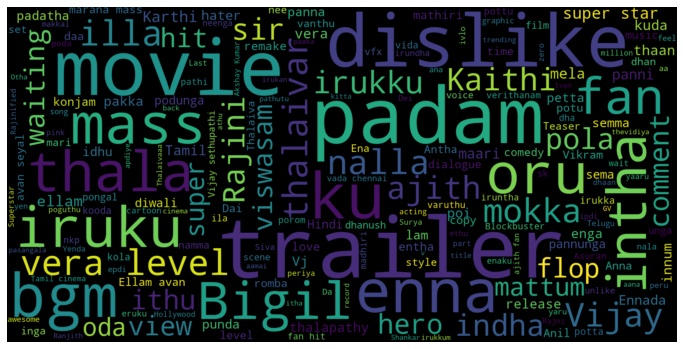

In [101]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Word Cloud for positively classified reviews**

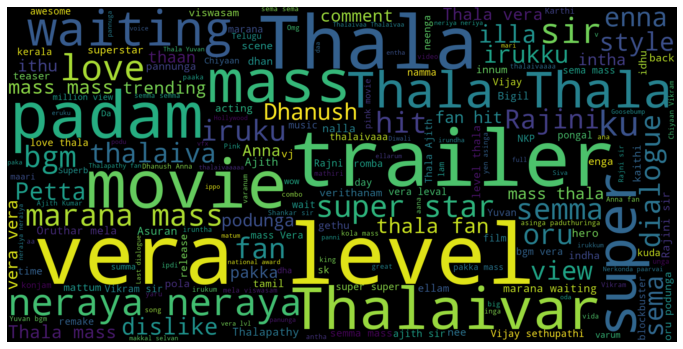

In [102]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_text)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Term Frequencies of each Sentiment class**

In [103]:
from sklearn.feature_extraction.text import CountVectorizer
cvector = CountVectorizer(min_df = 0.0, max_df = 1.0, ngram_range=(1,2))
cvector.fit(comment.review_Split)

CountVectorizer(min_df=0.0, ngram_range=(1, 2))

In [104]:
len(cvector.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


71249

In [105]:
neg_matrix = cvector.transform(comment[comment.label == 1].review_Split)
pos_matrix = cvector.transform(comment[comment.label == 0].review_Split)

In [106]:
neg_words = neg_matrix.sum(axis=0)
neg_words_freq = [(word, neg_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
neg_tf = pd.DataFrame(list(sorted(neg_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','negative'])

**Term Frequency for 'Negative' sentiments**

In [107]:
neg_tf.head()

,Terms,negative
0,trailer,182
1,movie,164
2,padam,155
3,dislike,129
4,bgm,103


In [108]:
neg_tf_df = neg_tf.set_index('Terms')
neg_tf_df.head()

,negative
Terms,
trailer,182
movie,164
padam,155
dislike,129
bgm,103


**Term Frequency for 'positive' sentiments**

In [109]:
pos_words = pos_matrix.sum(axis=0)
pos_words_freq = [(word, pos_words[0, idx]) for word, idx in cvector.vocabulary_.items()]
pos_words_tf = pd.DataFrame(list(sorted(pos_words_freq, key = lambda x: x[1], reverse=True)),columns=['Terms','positive'])
pos_words_tf_df = pos_words_tf.set_index('Terms')
pos_words_tf_df.head()

,positive
Terms,
thala,2467
mass,1644
vera,1253
level,1030
trailer,967


In [110]:
term_freq_df = pd.concat([neg_tf_df,pos_words_tf_df],axis=1)

**Total Term Frequency of all the sentiment classes**

In [111]:
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive'] 
term_freq_df.sort_values(by='total', ascending=False).head(20)

,negative,positive,total
Terms,,,
thala,87,2467,2554
mass,100,1644,1744
vera,89,1253,1342
trailer,182,967,1149
level,80,1030,1110
vera level,60,853,913
super,70,837,907
movie,164,685,849
fan,91,696,787


**Frequency plot of top frequent 500 phrases in movie reviews**

Text(0.5, 1.0, 'Top 500 phrases in comments')

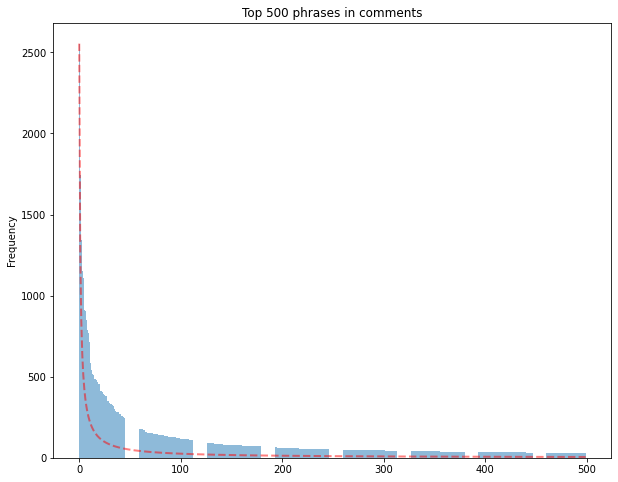

In [112]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 phrases in comments')

Plot of Absolute frequency of phrases against their rank

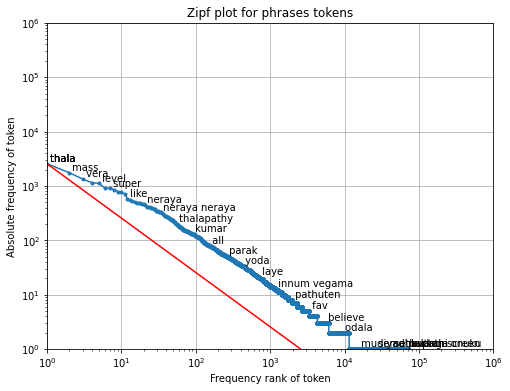

In [113]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for phrases tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

## **Reviews Tokens Visualisation**

**Plot of top frequently used 50 phrases in Negetive reviews**

Text(0.5, 1.0, 'Top 50 tokens in negative movie reviews')

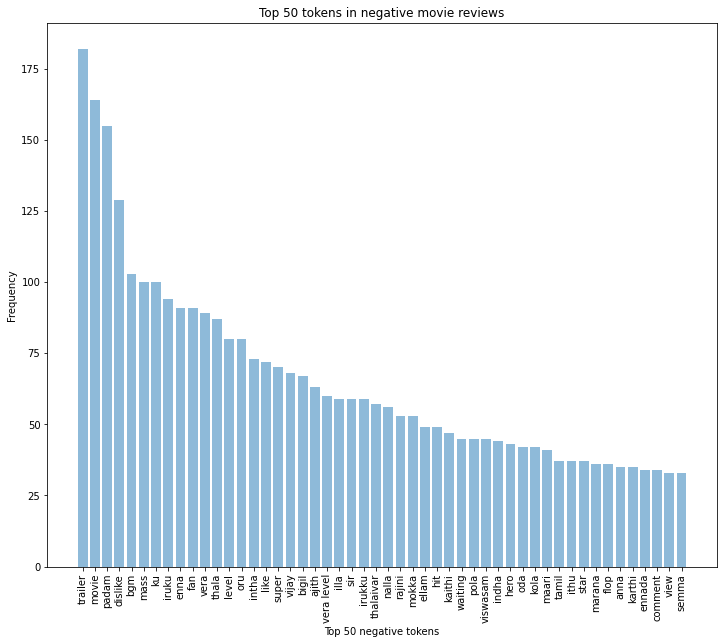

In [114]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative movie reviews')

**Plot of top frequently used 50 phrases in positive reviews**

Text(0.5, 1.0, 'Top 50 tokens in positive movie reviews')

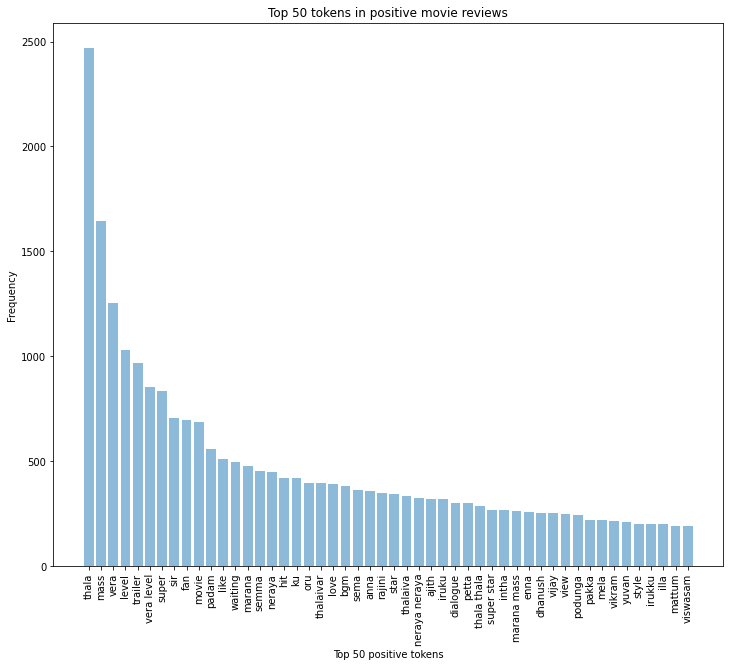

In [115]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive movie reviews')

In [116]:
comment.head()

,sentiment,review,review_Split,label
0,Negative,Enna da ellam avan seyal Mari iruku,Enna ellam avan seyal Mari iruku,1
1,Negative,This movei is just like ellam avan seyal,This movei ellam avan seyal,1
2,Positive,Padam vanthathum 13k dislike pottavaga yellam...,Padam vanthathum dislike pottavaga yellam yea ...,0
3,Positive,Neraya neraya neraya... ... V era level...thala,Neraya neraya neraya V level thala,0
4,Positive,wow thavala sema mass....padam oru pundaikum ...,wow thavala sema mass padam oru pundaikum aagathu,0


## **Feature Engineering**

In [117]:
# Let us balance the dataset
comment_imbalanced = comment
from sklearn.utils import resample
df_majority = comment[comment.label==0]
df_minority = comment[comment.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
print("Before")
print(comment.label.value_counts())
print("After")
print(df_upsampled.label.value_counts())
x_train, x_test, y_train, y_test = train_test_split(df_upsampled['review_Split'], df_upsampled['label'], test_size=0.3, stratify=df_upsampled['label'])
print("Train Data size:", len(x_train))
print("Test Data size", len(x_test))

Before
0    10559
1     2037
Name: label, dtype: int64
After
0    10559
1    10559
Name: label, dtype: int64
Train Data size: 14782
Test Data size 6336


In [118]:
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [119]:
def stem(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

vectorizer = CountVectorizer(
    analyzer = 'word',
    ngram_range=(1, 3))

In [120]:
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [ ]:
from scipy import stats

In [ ]:
np.random.seed(1)

pipeline_svm = make_pipeline(vectorizer, 
                            SVC(probability=True, kernel="linear", class_weight="balanced"))

grid_svm = GridSearchCV(pipeline_svm,
                    param_grid = {'svc__C': [0.01, 0.1, 1]}, 
                    cv = kfolds,
                    scoring="roc_auc",
                    verbose=1,   
                    n_jobs=-1) 

grid_svm.fit(x_train, y_train)
grid_svm.score(x_test, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.9892718616085094

In [ ]:
grid_svm.best_params_

{'svc__C': 1}

In [ ]:
grid_svm.best_score_

0.9831519328761938

In [ ]:
def report_results(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    pred = model.predict(X)        

    auc = roc_auc_score(y, pred_proba)
    acc = accuracy_score(y, pred)
    f1 = f1_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    result = {'auc': auc, 'f1': f1, 'acc': acc, 'precision': prec, 'recall': rec}
    return result

In [ ]:
report_results(grid_svm.best_estimator_, x_test, y_test)

{'auc': 0.9892718616085093,
 'f1': 0.9621387729871735,
 'acc': 0.9613320707070707,
 'precision': 0.942476536481986,
 'recall': 0.9826388888888888}

In [ ]:
def get_roc_curve(model, X, y):
    pred_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, pred_proba)
    return fpr, tpr

In [ ]:
roc_svm = get_roc_curve(grid_svm.best_estimator_, x_test, y_test)

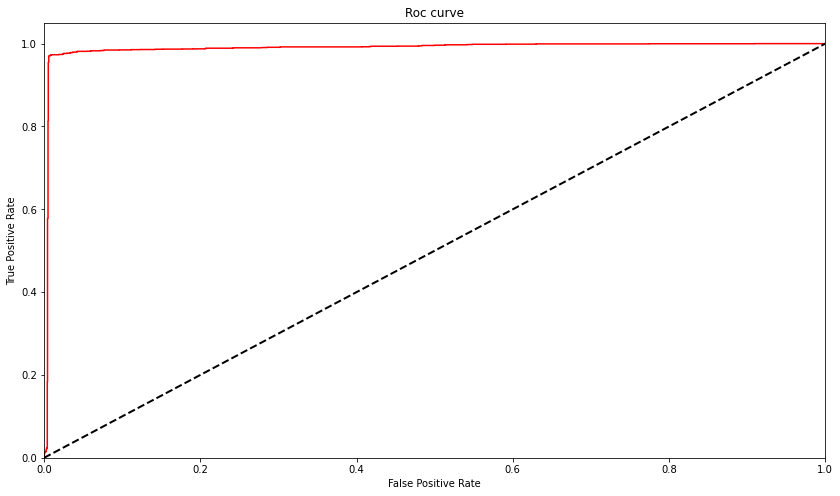

In [ ]:
fpr, tpr = roc_svm
plt.figure(figsize=(14,8))
plt.plot(fpr, tpr, color="red")
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc curve')
plt.show()

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(grid_svm.best_estimator_, x_train, y_train, cv=5, n_jobs=-1, 
                   scoring="roc_auc", train_sizes=np.linspace(.1, 1.0, 10), random_state=1)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title='', ylim=None, figsize=(14,8)):

    plt.figure(figsize=figsize)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt


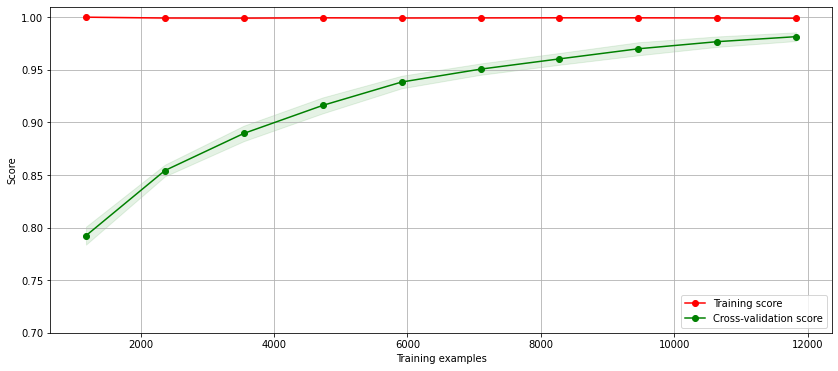

In [ ]:
plot_learning_curve(x_train, y_train, train_sizes, 
                    train_scores, test_scores, ylim=(0.7, 1.01), figsize=(14,6))
plt.show()

In [122]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB()

In [123]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer()
tf_train=vect.fit_transform(x_train)  #train the vectorizer, build the vocablury
tf_test=vect.transform(x_test)  #get same encodings on test data as of vocabulary built

In [124]:
model.fit(X=tf_train,y=y_train)

MultinomialNB()

In [125]:
expected = y_test
predicted=model.predict(tf_test)

In [127]:
from sklearn import metrics
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      3168
           1       0.83      0.85      0.84      3168

    accuracy                           0.84      6336
   macro avg       0.84      0.84      0.84      6336
weighted avg       0.84      0.84      0.84      6336

[[2598  570]
 [ 469 2699]]


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f227f99d710>)

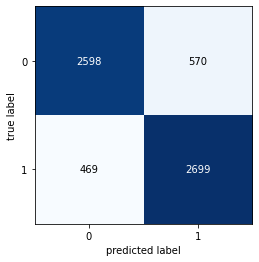

In [128]:
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(metrics.confusion_matrix(expected, predicted))

In [131]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [145]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'clf__penalty': ['l2'],
               'clf__C': [0.01, 0.1, 1.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l2'],
               'clf__C': [0.01, 0.1, 1.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=42))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=kfolds,
                           verbose=1,
                           n_jobs=-1)


In [146]:
gs_lr_tfidf.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.01, 0.1, 1.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)]},
                         {'clf__C': [0.01, 0.1, 1.0], 'clf__penalty': ['l2'],
                          'vect__ngram_range': [(1, 1)], 'vect__norm': [None],
                          'vect__use_idf': [False]}],
             scoring='accuracy', verbose=1)

In [147]:
print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__use_idf': False}
Best accuracy: 0.879


In [149]:
clf = gs_lr_tfidf.best_estimator_
print('Accuracy in test: %.3f' % clf.score(x_test, y_test))

Accuracy in test: 0.896
